## Goal

Expedia has provided you logs of customer behavior. These include what customers searched for, how they interacted with search results (click/book), whether or not the search result was a travel package. The data in this competition is a random selection from Expedia and is not representative of the overall statistics.

Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

Your goal of this competition is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event.

The train and test datasets are split based on time: training data from 2013 and 2014, while test data are from 2015. The public/private leaderboard data are split base on time as well. Training data includes all the users in the logs, including both click events and booking events. Test data only includes booking events. 

destinations.csv data consists of features extracted from hotel reviews text. 

Note that some srch_destination_id's in the train/test files don't exist in the destinations.csv file. This is because some hotels are new and don't have enough features in the latent space. Your algorithm should be able to handle this missing information.

## Data Dictionary

|Column name|Description|Data type|
|-----------|-----------|---------|
|date_time|Timestamp|string|
|site_name|ID of the Expedia point of sale(i.e.Expedia.com,Expedia.co.uk, Expedia.co.jp, ...)|int|
|posa_continent|ID of continent associated with site_name|int|
|user_location_country|The ID of the country the customer is located|int|
|user_location_region|The ID of the region the customer is located|int|
|user_location_city|The ID of the city the customer is located	|int|
|orig_destination_distance|Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated|float|
|user_id|ID of user|int|
|is_mobile|1 when a user connected from a mobile device, 0 otherwise|int|
|is_package|1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise|int|
|channel|ID of a marketing channel|int|
|srch_ci|Checkin date|string|
|srch_co|Checkout date|string|
|srch_adults_cnt|The number of adults specified in the hotel room|int|
|srch_children_cnt|The number of (extra occupancy) children specified in the hotel room|int|
|srch_rm_cnt|The number of hotel rooms specified in the search	|int|
|srch_destination_id|ID of the destination where the hotel search was performed|int|
|srch_destination_type_id|Type of destination|int|
|hotel_continent|Hotel continent|int|
|hotel_country|Hotel country|int|
|hotel_market|Hotel market|int|
|is_booking|1 if a booking, 0 if a click|int|
|cnt|Numer of similar events in the context of the same user session|int|
|hotel_cluster|ID of a hotel cluster|int|

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [194]:
expedia = pd.read_csv("../../Datasets/Expedia Data/train.csv", nrows=20001)

In [195]:
exp_test = pd.read_csv("../../Datasets/Expedia Data/test.csv", nrows=20001)

In [196]:
print expedia.info()
print "-------------------"
print exp_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 24 columns):
date_time                    20001 non-null object
site_name                    20001 non-null int64
posa_continent               20001 non-null int64
user_location_country        20001 non-null int64
user_location_region         20001 non-null int64
user_location_city           20001 non-null int64
orig_destination_distance    11869 non-null float64
user_id                      20001 non-null int64
is_mobile                    20001 non-null int64
is_package                   20001 non-null int64
channel                      20001 non-null int64
srch_ci                      19989 non-null object
srch_co                      19989 non-null object
srch_adults_cnt              20001 non-null int64
srch_children_cnt            20001 non-null int64
srch_rm_cnt                  20001 non-null int64
srch_destination_id          20001 non-null int64
srch_destination_type_id     20001 n

In [197]:
expedia.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [198]:
exp = pd.DataFrame(expedia)

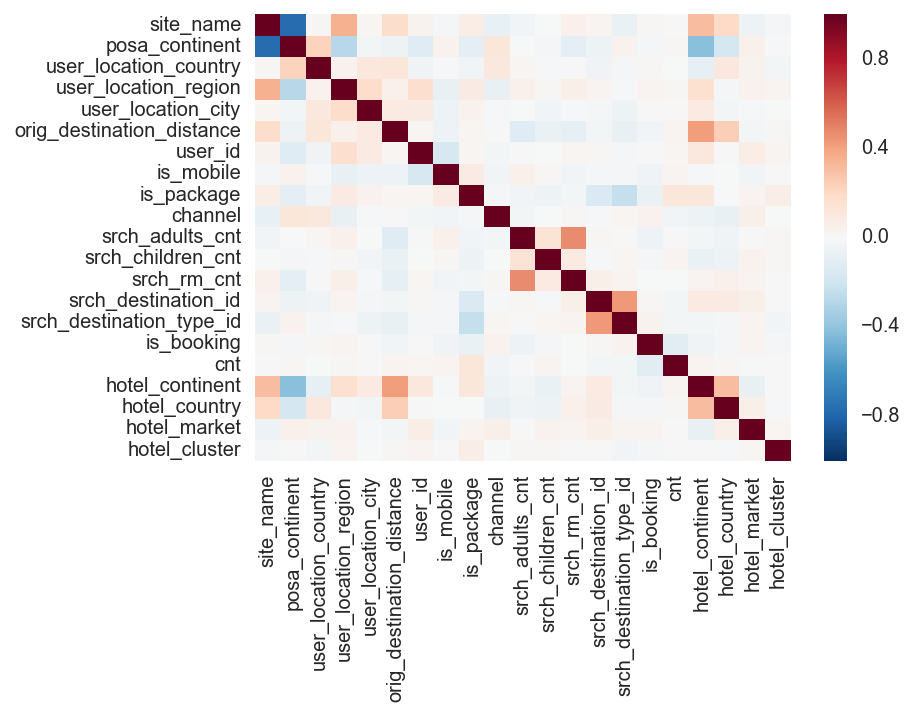

In [199]:
sns.heatmap(exp.corr())

In [201]:
exp['date_time'] = pd.to_datetime(exp['date_time'])
exp['srch_ci'] = pd.to_datetime(exp['srch_ci'])
exp['srch_co'] = pd.to_datetime(exp['srch_co'])
exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 24 columns):
date_time                    20001 non-null datetime64[ns]
site_name                    20001 non-null int64
posa_continent               20001 non-null int64
user_location_country        20001 non-null int64
user_location_region         20001 non-null int64
user_location_city           20001 non-null int64
orig_destination_distance    11869 non-null float64
user_id                      20001 non-null int64
is_mobile                    20001 non-null int64
is_package                   20001 non-null int64
channel                      20001 non-null int64
srch_ci                      19989 non-null datetime64[ns]
srch_co                      19989 non-null datetime64[ns]
srch_adults_cnt              20001 non-null int64
srch_children_cnt            20001 non-null int64
srch_rm_cnt                  20001 non-null int64
srch_destination_id          20001 non-null int64
srch_destina

66     11017
69      2067
205     1386
3        897
46       829
23       398
70       276
62       228
77       194
231      189
Name: user_location_country, dtype: int64


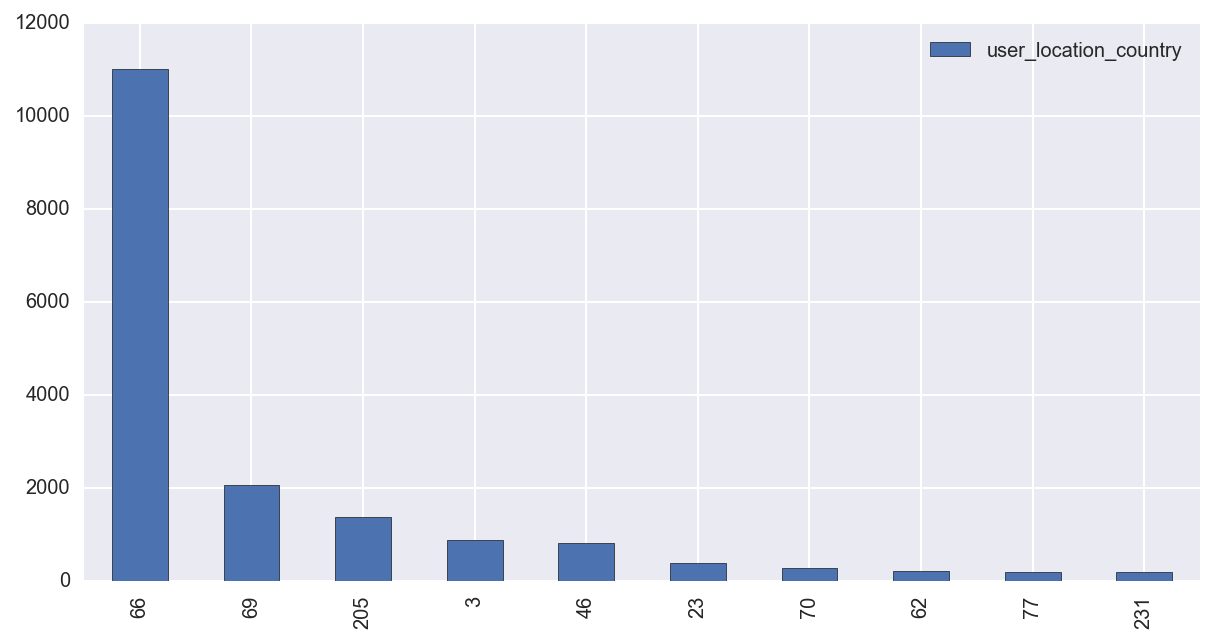

In [280]:
# What country are most of the searches from?

print exp['user_location_country'].value_counts().head(10)

plt.figure(figsize=(10,5))
exp['user_location_country'].value_counts().head(10).plot(legend=True, kind='bar')

0    18422
1     1579
Name: is_booking, dtype: int64


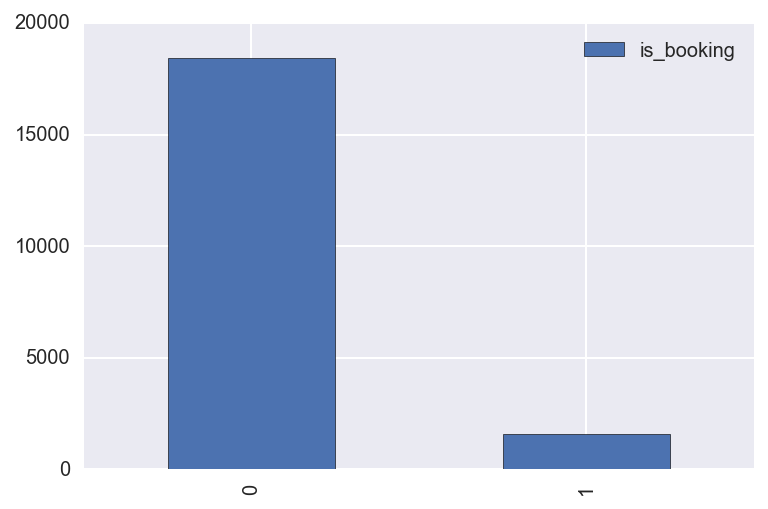

In [279]:
# How many bookings?

print exp['is_booking'].value_counts()
exp['is_booking'].value_counts().plot(legend=True, kind='bar')

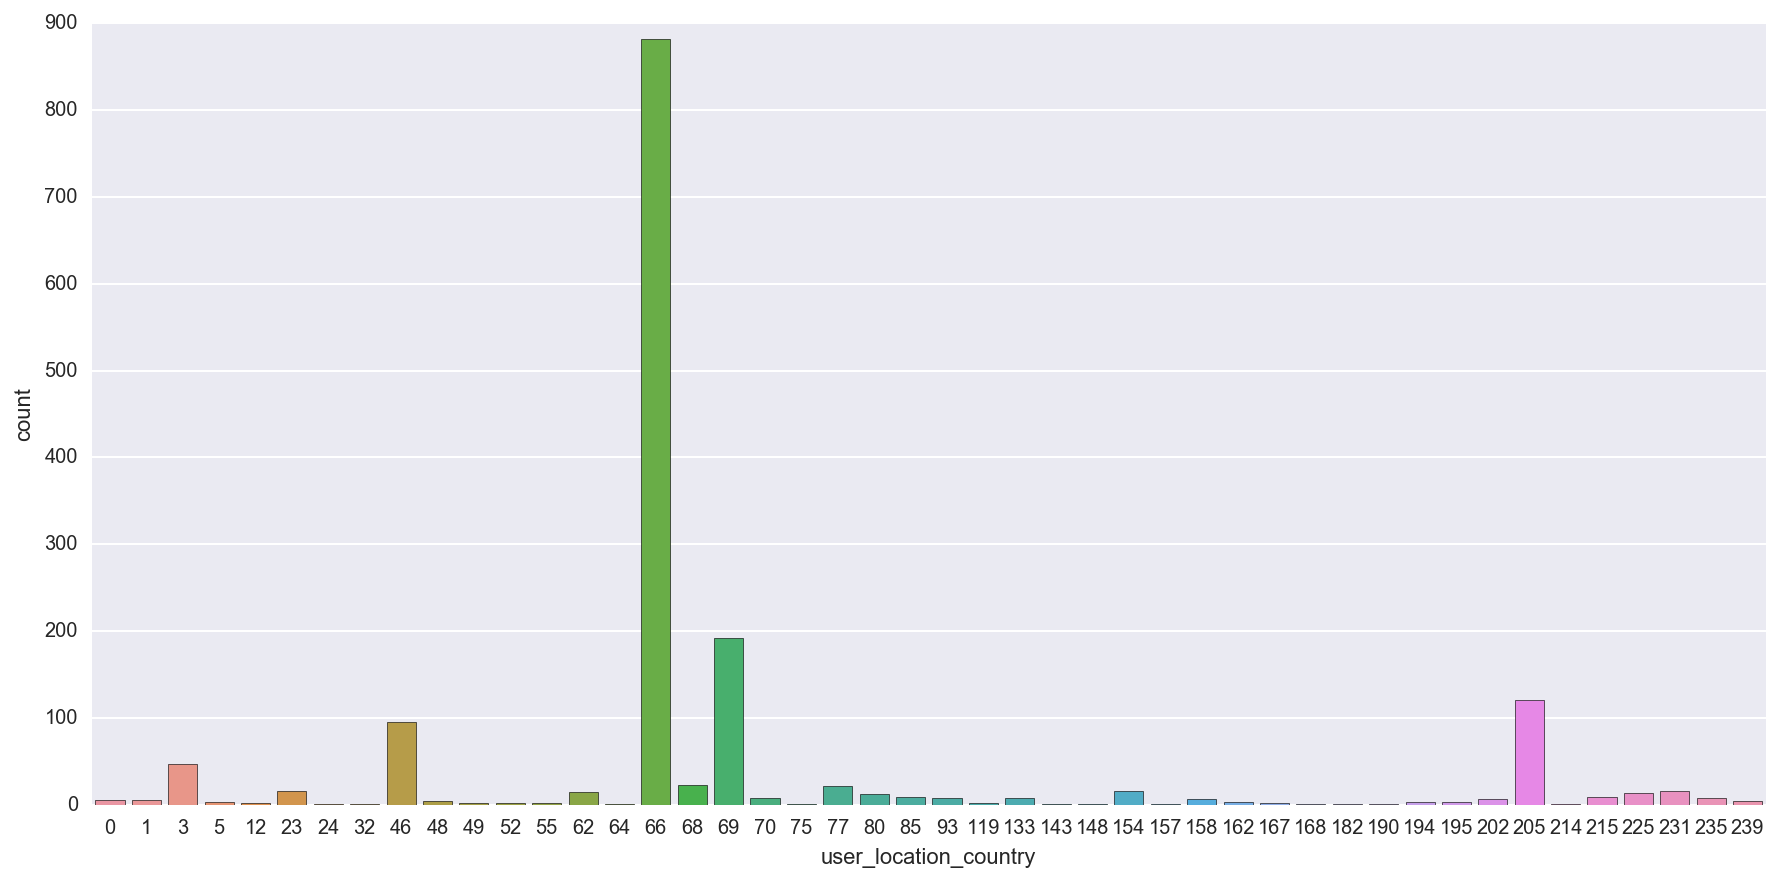

In [204]:
# What country's have the most bookings?

booked = exp[exp['is_booking'] == 1]

fig = plt.figure(figsize=(15,7))
sns.countplot(booked['user_location_country'], data=booked)

2    912
6    338
3    181
4    103
0     23
5     22
Name: hotel_continent, dtype: int64


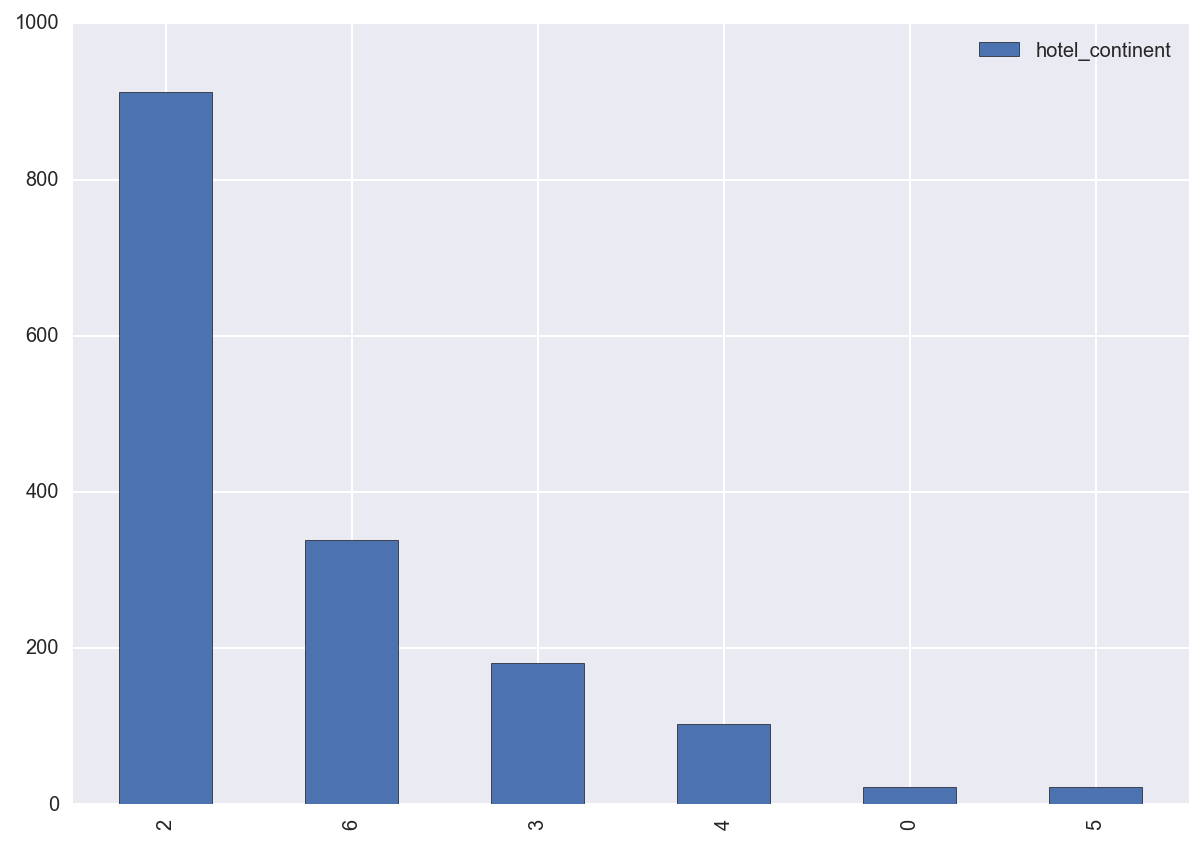

In [278]:
# What continent do most people travel?

print booked['hotel_continent'].value_counts()

fig = plt.figure(figsize=(10,7))
booked['hotel_continent'].value_counts().plot(legend=True, kind='bar')

50     837
70      94
198     75
105     60
182     35
Name: hotel_country, dtype: int64


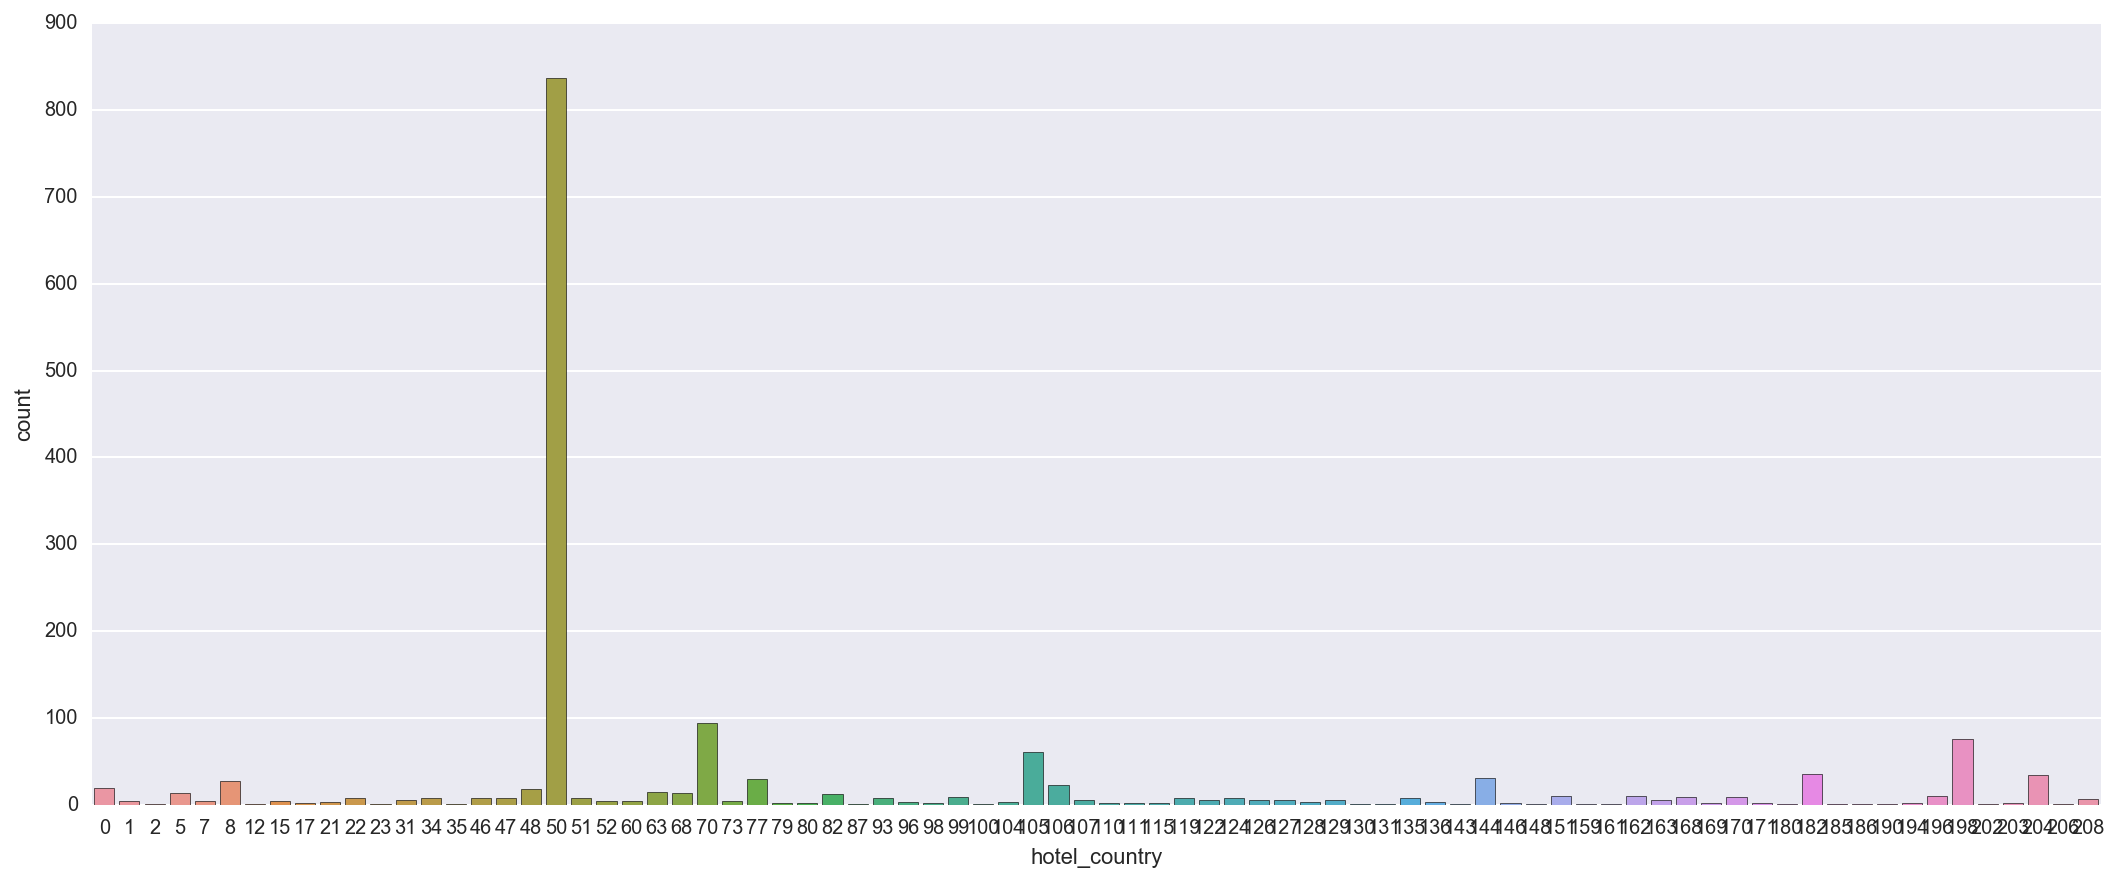

In [206]:
# What country do most people travel to?

print booked['hotel_country'].value_counts().head()

fig = plt.figure(figsize=(18,7))

sns.countplot(booked['hotel_country'], data=booked)

0    1346
1     233
Name: is_package, dtype: int64


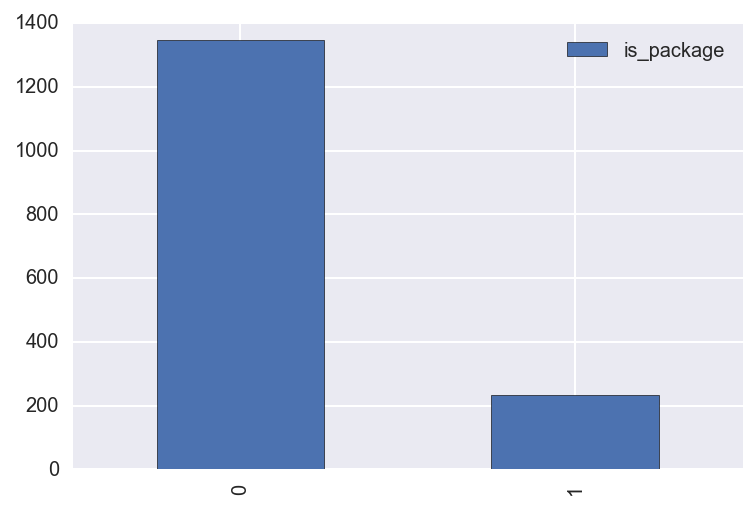

In [277]:
# How many booked and was a package?

print booked['is_package'].value_counts()

booked['is_package'].value_counts().plot(legend=True, kind='bar')

0    1410
1     169
Name: is_mobile, dtype: int64


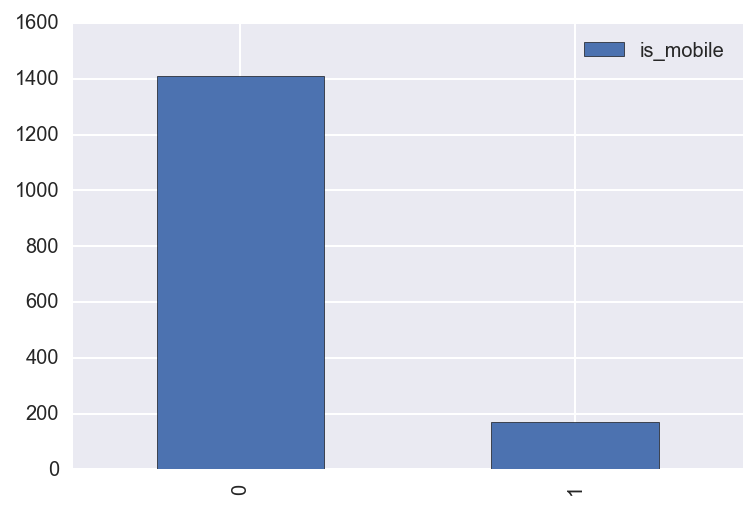

In [276]:
# How many booked was on mobile?

print booked['is_mobile'].value_counts()

booked['is_mobile'].value_counts().plot(legend=True, kind=('bar'))

1    12540
6     4645
3     1298
5      929
4      533
8       54
7        2
Name: srch_destination_type_id, dtype: int64


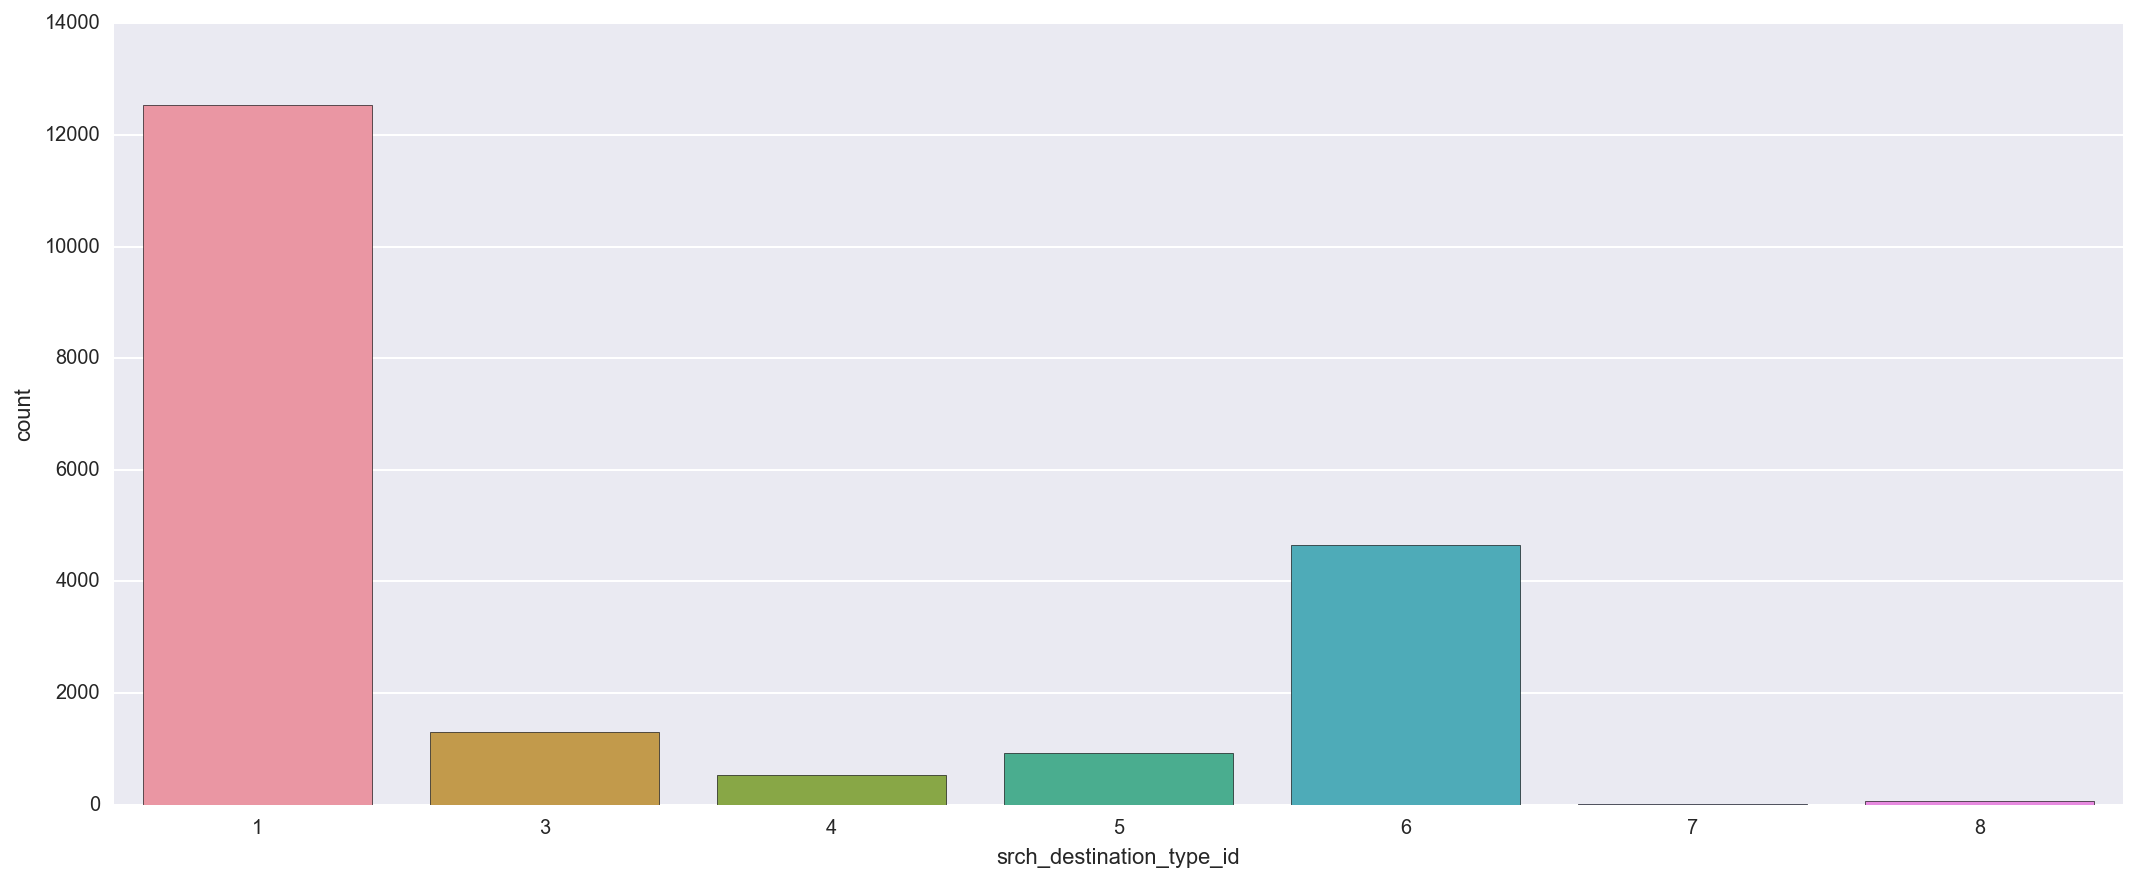

In [210]:
# Most searched destination type?

print exp['srch_destination_type_id'].value_counts()

fig = plt.figure(figsize=(18,7))

sns.countplot(exp['srch_destination_type_id'])

In [211]:
print exp['date_time'].min()
print exp['date_time'].max()

2013-01-07 09:47:43
2014-12-31 22:57:00


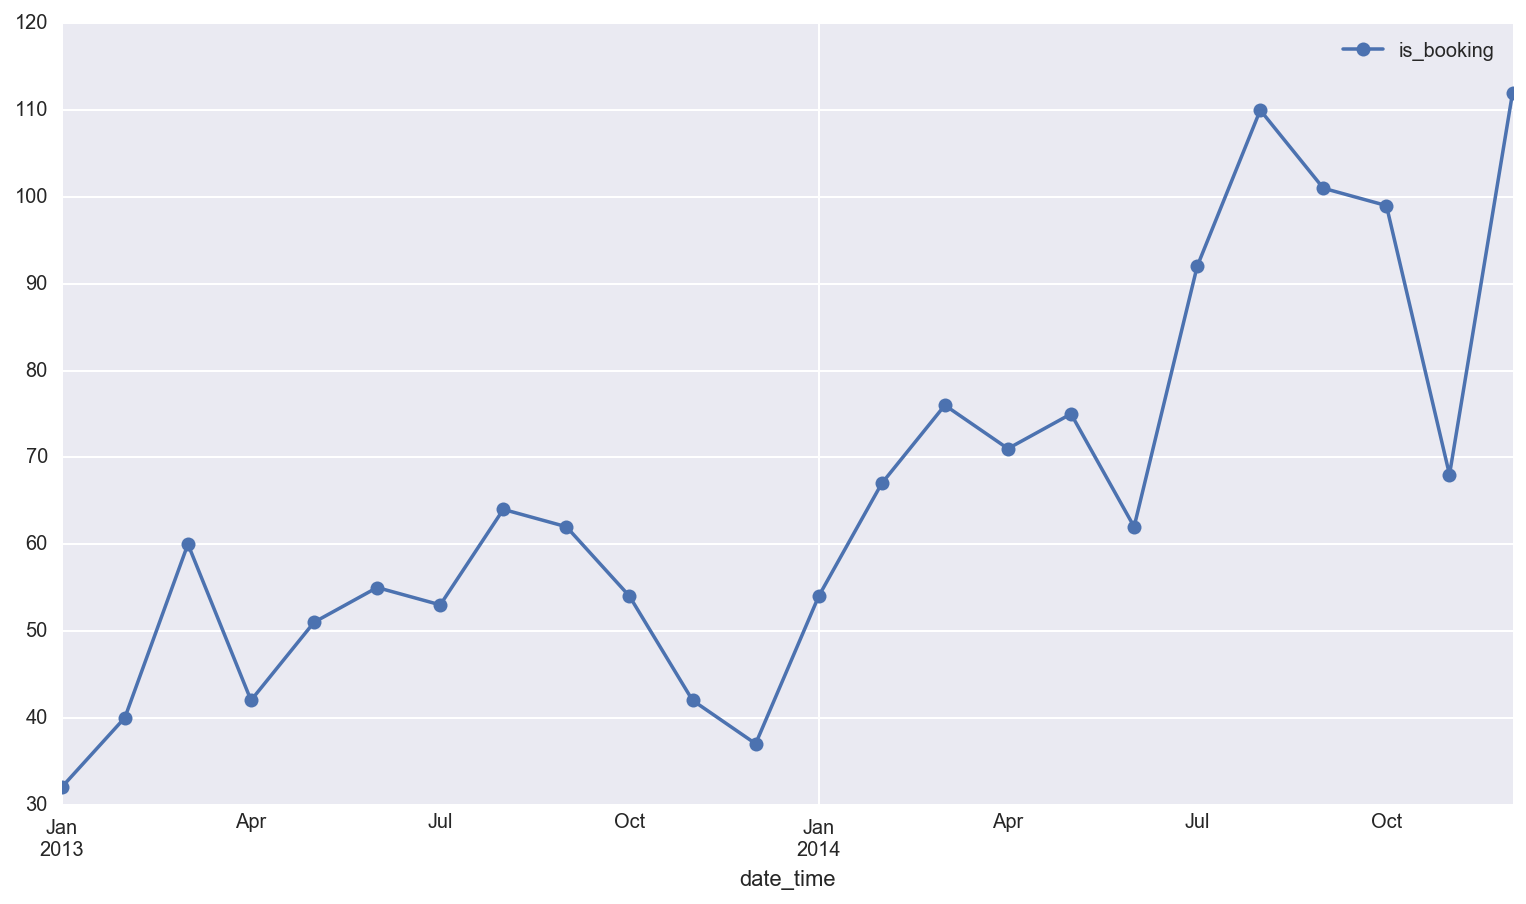

In [275]:
# The number of bookings during the year

date_booked = booked.groupby(booked.date_time.dt.to_period("M"))['is_booking'].sum()

fig = plt.figure(figsize=(13,7))

date_booked.plot(legend=True, marker='o')

In [200]:
exp.isnull().sum()

date_time                       0
site_name                       0
posa_continent                  0
user_location_country           0
user_location_region            0
user_location_city              0
orig_destination_distance    8132
user_id                         0
is_mobile                       0
is_package                      0
channel                         0
srch_ci                        12
srch_co                        12
srch_adults_cnt                 0
srch_children_cnt               0
srch_rm_cnt                     0
srch_destination_id             0
srch_destination_type_id        0
is_booking                      0
cnt                             0
hotel_continent                 0
hotel_country                   0
hotel_market                    0
hotel_cluster                   0
dtype: int64